LC ladder: N=100, L_sec=3.500e-10 H, C_sec=1.400e-13 F
Peak pos ~ 2.024 kV, peak neg ~ -0.691 kV


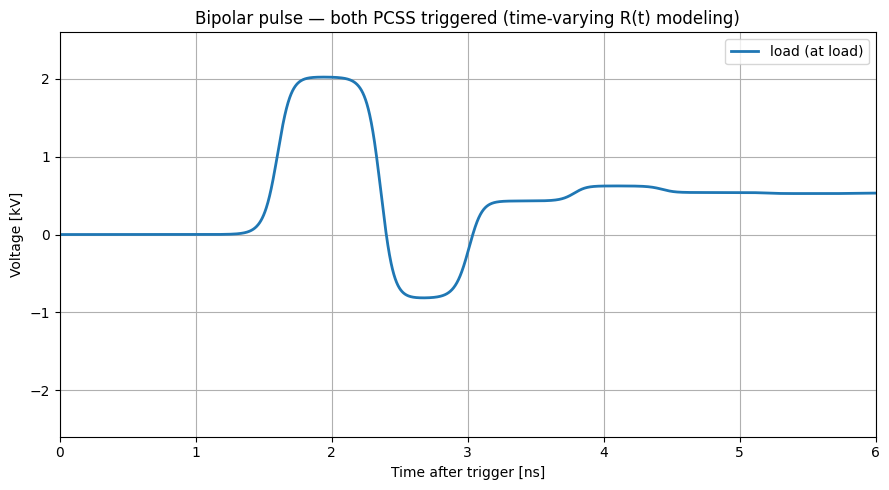

In [20]:
# Bipolar case: both PCSS1 and PCSS2 triggered (time-varying R(t) for each)
# Paste into Jupyter. Requires PySpice + ngspice on PATH.

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Parameters ----------------
V_batt = 4500.0          # supply (V)
R_bias = 50             # 1 kΩ charging resistor
Z0 = 50.0
TD = 0.7e-9              # line delay
N_sections = 100          # ladder sections

# Time-varying resistor parameters (Gaussian turn-on)
# You can tune these to match the paper's bipolar waveform
Ron_left  = 10.0         # final ON resistance for PCSS1 (ohm)
Ron_right = 10.0         # final ON resistance for PCSS2 (ohm)
Roff_val  = 1e9          # off resistance (very large)
tau_val   = 0.4e-9       # gaussian width (s) ~0.4 ns
# Trigger times (seconds) - when each PCSS centers its Gaussian
# For truly simultaneous firing set them equal; else small offset
trigger_time = 200e-9    # main trigger time (s) -- long precharge
t_left  = trigger_time   # left pcss center
t_right = trigger_time   # right pcss center
# small offset example: t_left = trigger_time; t_right = trigger_time + 20e-12

# small series resistances for damping (keep small to preserve energy)
Rseries_left  = 1.0      # between node_bias and line_in (stabilize)
Rseries_right = 1.0      # between tx_right and R(t) node

# control pulse string (for timing reference only)
ctrl_rise = 0.2e-9
ctrl_fall = 0.05e-9
ctrl_on_time = 1.1e-9
period = 1e-6
ctrl_pulse_str = f'PULSE(0 5 {trigger_time*1e9:.3f}n {ctrl_rise*1e9:.3f}n {ctrl_fall*1e9:.3f}n {ctrl_on_time*1e9:.3f}n {period*1e9:.3f}n)'

# Derived LC per-section values
tau_section = TD / N_sections
L_sec = Z0 * tau_section
C_sec = tau_section / Z0

print(f'LC ladder: N={N_sections}, L_sec={L_sec:.3e} H, C_sec={C_sec:.3e} F')

# ---------------- Build circuit ----------------
circuit = Circuit('bipolar_pulse_R_of_t')

# battery + charging resistors (left end charged through R_bias)
circuit.V('batt', 'vbatt', circuit.gnd, V_batt @ u_V)
circuit.R('rbias', 'vbatt', 'node_bias', R_bias @ u_Ohm)

# control source for timing reference (not used to drive the behavioral resistors directly)
circuit.V('ctrl', 'ctrl', circuit.gnd, ctrl_pulse_str)

# small series resistor to line_in for stability
circuit.R('left_series', 'node_bias', 'line_in', Rseries_left @ u_Ohm)

# LC-ladder from line_in -> ... -> tx_right
ladder_nodes = ['line_in']
for i in range(1, N_sections + 1):
    ladder_nodes.append(f'n{i}')
ladder_nodes[-1] = 'tx_right'

for i in range(1, len(ladder_nodes)):
    circuit.L(f'L{i}', ladder_nodes[i-1], ladder_nodes[i], L_sec @ u_H)
    circuit.C(f'C{i}', ladder_nodes[i], circuit.gnd, C_sec @ u_F)

# small series resistor before the right time-varying resistor
circuit.R('r_right_series', 'tx_right', 'tx_right_sw', Rseries_right @ u_Ohm)

# Left PCSS: implement R_left(t) between node_bias and ground (this models PCSS1 shorting left end)
# We'll use a behavioral resistor Rl between node_bias and ground with expression Rl(t) = Ron_left + (Roff-Ron_left)*exp(-((time - t_left)/tau)^2)
# Because node_bias is the charging node, we implement Rleft between node_bias and ground.
raw_rleft = ("Rleft node_bias 0 r={%g + (%g - %g)*exp(-((time - %g)/%g)**2)}\n"
             % (Ron_left, Roff_val, Ron_left, t_left, tau_val))

# Right PCSS: Rright between tx_right_sw and load_node
raw_rright = ("Rright tx_right_sw load_node r={%g + (%g - %g)*exp(-((time - %g)/%g)**2)}\n"
              % (Ron_right, Roff_val, Ron_right, t_right, tau_val))

# Append raw lines (handle raw_spice string vs list)
if isinstance(circuit.raw_spice, str):
    circuit.raw_spice += raw_rleft
    circuit.raw_spice += raw_rright
else:
    circuit.raw_spice.append(raw_rleft.strip())
    circuit.raw_spice.append(raw_rright.strip())

# Matched 50 ohm load at load_node
circuit.R('RL', 'load_node', circuit.gnd, Z0 @ u_Ohm)

# ---------------- Simulation ----------------
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

# simulate until a bit after the pulse: end_time = trigger_time + 8 ns
end_time = trigger_time + 8e-9
step_time = 2e-12  # 2 ps
analysis = simulator.transient(step_time=step_time @ u_s, end_time=end_time @ u_s)

# ---------------- Extract & time-shift (0 = trigger_time) ----------------
time_s = np.array(analysis.time)
t_shift = (time_s - trigger_time) * 1e9  # ns

# helper to get node case-insensitively
def get_node(analysis, name):
    for k in analysis.nodes.keys():
        if k.lower() == name.lower():
            return np.array(analysis.nodes[k])
    raise KeyError(name)

v_load = get_node(analysis, 'load_node') / 1e3      # kV
v_node_bias = get_node(analysis, 'node_bias') / 1e3  # kV (debug)
v_tx_right = get_node(analysis, 'tx_right') / 1e3    # kV (debug)

# mask for plotting 0..6 ns after trigger
mask = (t_shift >= 0.0) & (t_shift <= 6.0)

# plateau stats for positive/negative peaks (approx)
# For bipolar, find max positive and min negative within 0..2.5 ns
mask_peak = (t_shift >= 0.0) & (t_shift <= 2.5)
if mask_peak.any():
    peak_pos = v_load[mask_peak].max()
    peak_neg = v_load[mask_peak].min()
    print(f'Peak pos ~ {peak_pos:.3f} kV, peak neg ~ {peak_neg:.3f} kV')

# ---------------- Plot ----------------
plt.figure(figsize=(9,5))
plt.plot(t_shift[mask], v_load[mask], linewidth=2.0, label='load (at load)')
# optional debug traces -- uncomment if you want to inspect internal nodes
# plt.plot(t_shift[mask], v_tx_right[mask], '--', label='tx_right (internal)')
# plt.plot(t_shift[mask], v_node_bias[mask], ':', label='node_bias (left)')
plt.xlim(0,6)
plt.ylim(-2.6,2.6)   # bipolar expected
plt.xlabel('Time after trigger [ns]')
plt.ylabel('Voltage [kV]')
plt.title('Bipolar pulse — both PCSS triggered (time-varying R(t) modeling)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
